In [1]:
import networkx as nx
from pymdp.jax.envs import GraphEnv

def generate_connected_clusters(cluster_size=2, connections=2):
    edges = []
    connecting_node = 0
    while connecting_node < connections * cluster_size:
        edges += [(connecting_node, a) for a in range(connecting_node + 1, connecting_node + cluster_size + 1)]
        connecting_node = len(edges)
    graph = nx.Graph()
    graph.add_edges_from(edges)
    return graph, {
        "locations": [
            (f"hallway {i}" if len(list(graph.neighbors(loc))) > 1 else f"room {i}")
            for i, loc in enumerate(graph.nodes)
        ]
    }

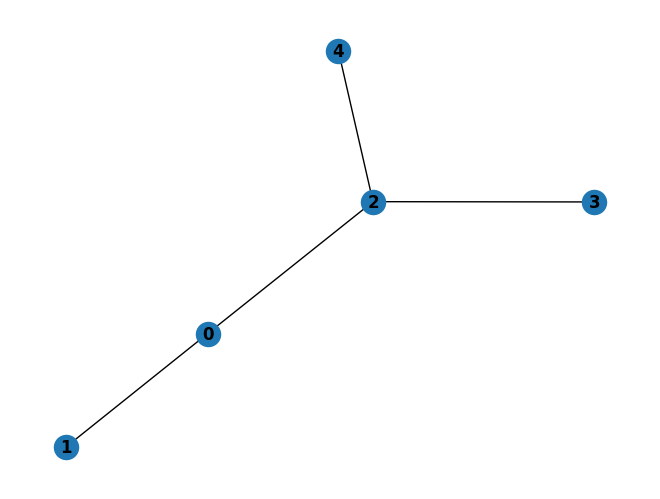

In [2]:
graph, _ = generate_connected_clusters(cluster_size=2, connections=2)
nx.draw(graph, with_labels=True, font_weight="bold")

In [3]:
from jax import random as jr
key = jr.PRNGKey(0)

env = GraphEnv(graph, 3, 0)

In [4]:
import jax.numpy as jnp

batch_size = 1
keys = jr.split(key, batch_size + 1)
key = keys[-1]

action = jnp.broadcast_to(jnp.array([4, 0]), (batch_size, 2))
print(action.shape)

_keys = keys[:batch_size]
print(jnp.shape(_keys))
obs = env.step(_keys, action)
print(obs)

(1, 2)
(1, 2)
([Array([0], dtype=int32), Array([0], dtype=int32)], GraphEnv(
  params={
    'A':
    [f32[1,5,5], f32[1,2,5,6]],
    'B':
    [f32[1,5,5,5], f32[1,6,6,1]],
    'D':
    [f32[1,5], f32[1,6]]
  },
  states=[[i32[1], i32[1]], [i32[1], i32[1]]],
  dependencies={'A': [[0], [0, 1]], 'B': [[0], [1]]}
))


In [5]:
from pymdp.jax.agent import Agent

A = [a.copy() for a in env.params["A"]]
B = [b.copy() for b in env.params["B"]]
A_dependencies = env.dependencies["A"]
B_dependencies = env.dependencies["B"]

C = [jnp.zeros(a.shape[:2]) for a in A]
C[1] = C[1].at[1].set(1.0)

D = [jnp.ones(b.shape[:2]) for b in B]

agent = Agent(A, B, C, D,None, None, None, A_dependencies=A_dependencies, B_dependencies=B_dependencies)

In [6]:
print(C[0].shape)

(1, 5)


In [7]:
print([a.shape for a in A])

[(1, 5, 5), (1, 2, 5, 6)]


In [14]:
# add a time dimension
qs = [jnp.broadcast_to(d, (1,) + d.shape) for d in D]

print([s.shape for s in qs])
q_pi, nefe = agent.infer_policies(qs)

[(1, 1, 5), (1, 1, 6)]


In [9]:
batch_keys = jr.split(key, batch_size + 1)
_keys = keys[:batch_size]
key = keys[-1]
actions = agent.sample_action(q_pi, rng_key=_keys)

In [10]:
print(actions)

[[1 0]]


In [11]:
batch_keys = jr.split(key, batch_size + 1)
_keys = keys[:batch_size]
key = keys[-1]
obs, _ = env.step(_keys, action)

In [18]:
print(obs)
# add time dim
obs_b = [jnp.broadcast_to(o, (1,) + o.shape) for o in obs]

print([s.shape for s in qs])
print(actions.shape)
prior, _ = agent.update_empirical_prior(actions, qs)

agent.infer_states(obs_b, None, prior, None)

[Array([0], dtype=int32), Array([0], dtype=int32)]
[(1, 1, 5), (1, 1, 6)]
(1, 2)


[Array([[[0.16048184, 0.35807264, 0.16048184, 0.16048184, 0.16048184]]],      dtype=float32),
 Array([[[3.0379263e-03, 2.4523251e-06, 3.0379263e-03, 3.0379263e-03,
          3.0379263e-03, 9.8784572e-01]]], dtype=float32)]